In [1]:
import geopandas as gpd
import folium
import os
from PIL import Image
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
#from geojson import Point
from geojson import Polygon
import geojson
import tempfile
import datetime as dt
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio import plot
import rasterio.mask
import fiona
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage import exposure

NDVI

Simply put, NDVI helps to differentiate vegetation from other types of land cover (artificial) and determine its overall state. It also allows to define and visualize vegetated areas on the map as well as detect abnormal changes in the growth process.
https://eos.com/blog/ndvi-faq-all-you-need-to-know-about-ndvi/

NDVI is calculated from the visible and near-infrared light reflected by vegetation. Healthy vegetation (left) absorbs most of the visible light that hits it, and reflects a large portion of near-infrared light. Unhealthy or sparse vegetation (right) reflects more visible light and less near-infrared light. Source: NASA


The normalized difference vegetation index (NDVI) uses a ratio between near infrared and red light within the electromagnetic spectrum. To calculate NDVI you use the following formula where NIR is near infrared light and red represents red light. For your raster data, you will take the reflectance value in the red and near infrared bands to calculate the index.

(NIR - Red) / (NIR + Red)

In [2]:
# import bands as separate 1 band raster
imagePath = 'C:/Users/X409/Desktop/project/pythonProject/data/S2A_MSIL1C_20210517T095031_N0300_R079_T33SVV_20210517T110145.SAFE/GRANULE/L1C_T33SVV_A030821_20210517T095358/IMG_DATA/'

# Load polygon vector of AI (e.g.Gozo) to clip satellite image
boundsdata = r'C:/Users/X409/Desktop/project/pythonProject/data/Chadwick.geojson'
region = gpd.read_file(boundsdata)
print(region)
nReserve_proj = region.to_crs({'init': 'epsg:32633'})

   id                                           geometry
0   3  MULTIPOLYGON (((14.37243 35.89399, 14.37243 35...


C:\anaconda\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
# Open b4 and b8
b4 = rasterio.open(imagePath+'T33SVV_20210517T095031_B04.jp2')
b8 = rasterio.open(imagePath+'T33SVV_20210517T095031_B08.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()

# Do not display error when divided by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

#Print NDVI min and max
print(np.nanmin(ndvi))
print(np.nanmax(ndvi))

# get the dtype of our NDVI array:
ndvi_dtype = ndvi.dtype
print(ndvi_dtype)

# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float64)

with rasterio.open('C:/Users/X409/Desktop/project/pythonProject/Output/NDVI/NDVI3.tif', 'w', **meta) as dst:
    dst.write(ndvi)
    #dst.write(ndvi.astype(rasterio.float32))

-1.0
0.9935897435897436
float64


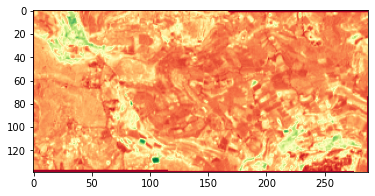

Min NDVI: 0.0
Max NDVI: 0.7535807291666666


In [4]:
# Crop NDVI to ROI

with rio.open("C:/Users/X409/Desktop/project/pythonProject/Output/NDVI/NDVI3.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('C:/Users/X409/Desktop/project/pythonProject/Output/NDVI/NDVI3_cropped.tif', 'w', **meta) as dst:
    dst.write(out_image)
plot.show(out_image, cmap='RdYlGn')

#Print NDVI min and max
print('Min NDVI:', np.nanmin(out_image))
print('Max NDVI:', np.nanmax(out_image))

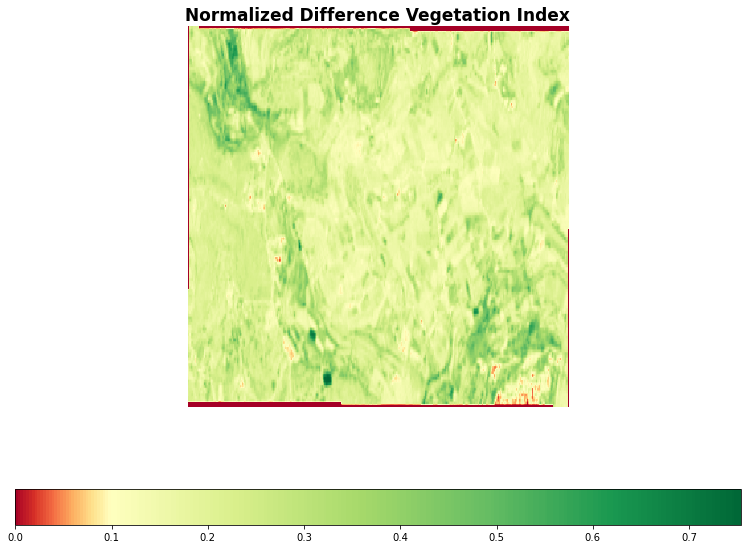

In [5]:
# Interpretation of NDVI


from matplotlib import colors


class MidpointNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):

        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Set min/max values from NDVI range for image

min=np.nanmin(out_image)
max=np.nanmax(out_image)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

ndvi_cropped = rasterio.open("C:/Users/X409/Desktop/project/pythonProject/Output/NDVI/NDVI3_cropped.tif")
# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndvi_cropped.read(1), cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels
ax.axis('off')

# Set a title
ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("C:/Users/X409/Desktop/project/pythonProject/Output/NDVI/ndvi3-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

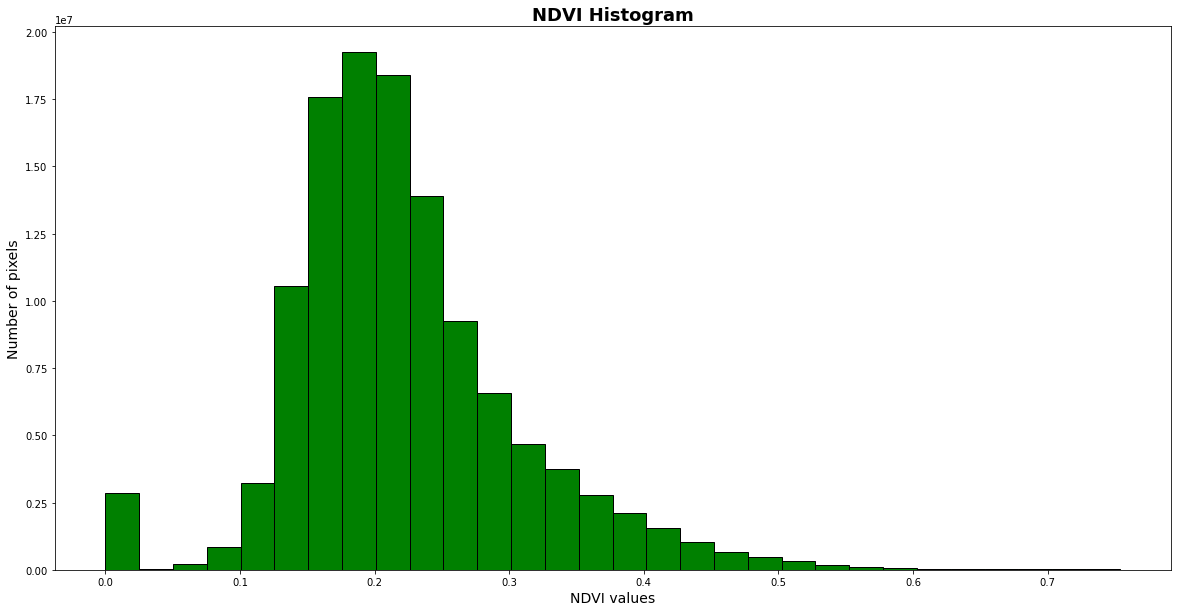

In [6]:
# Generate histogram of NDVI

# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = ndvi_cropped.read(1)[~np.isnan(ndvi_cropped.read(1))]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
#fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()

